In [1]:
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import  train_test_split
from sklearn.linear_model import LinearRegression, Ridge  # noqa F401
from category_encoders import OneHotEncoder
from sklearn.utils.validation import check_is_fitted
import matplotlib.pyplot as plt



#from category_encoders import OneHotEncoder


plt.style.use('ggplot')



In [2]:
def wrangle(Desktop):
    # Read CSV file
    df = pd.read_csv(Desktop)
    #subset to property in Karachi less than 300
    mask_ka =df["complete location"].str.contains("Sindh").fillna(False)
    #sunset to House
    mask_ouse = df["type"]=="House"
    df = df[mask_ka & mask_ouse]
    
    #slipting 'price'
    df[["Price", "currency"]] = df["price"].str.split(" ", expand = True)

    df["Price"] = df["Price"].astype(float)
    #df.drop(columns = ("Price","currency"), inplace = True)

    #Changing the 'Price to Float' and converting  crore to lakh
    df = df.assign(price = lambda x: x["Price"].mask(x["currency"] == "Crore", x["Price"] * 100))
    
    #dropping columns
    df.drop(columns = ["Price","currency"], inplace = True)
    df.drop(columns = ["date added","keywords", "url"], inplace = True)
    #dropping NaN values
    df = df.dropna()
    
    
    #slipting area, replaying ',' and changing obj. to float
    df["area"] = df["area"].str.split(" ", expand = True)[0]
    df.area= df.area.apply(lambda x:(x.replace(',','')))
    df["area"] = df["area"].astype(float)
    
    #subset remove outliers by "surface_covered_in_m2"
    low , high = df["area"].quantile([0.01, 0.9])
    mask_area = df["area"].between(low, high) 
    df = df[mask_area]
    #drop some columns
    df.drop(columns = ["title","complete location", "description"], inplace = True)
    
    #replacing values in columns
    df['location'] = df['location'].replace(["DHA Defence, Karachi, Sindh", "Bahria Town Karachi, Karachi, Sindh","Clifton, Karachi, Sindh"], ["DHA Defence Karachi", "Bahria Town Karachi", "Clifton Karachi"])




    

    


    return df

In [3]:
df = wrangle("karachi-pakistan-property-prices-2023.csv")
print("df shape:", df.shape)
df.head()

df shape: (3695, 6)


,price,type,bedrooms,bathrooms,area,location
0,1150.0,House,5,6,600.0,DHA Defence Karachi
5,900.0,House,7,6,500.0,DHA Defence Karachi
11,2000.0,House,6,6,1000.0,DHA Defence Karachi
14,1700.0,House,6,6,500.0,DHA Defence Karachi
16,725.0,House,3,4,545.0,DHA Defence Karachi


In [4]:
df.columns

Index(['price', 'type', 'bedrooms', 'bathrooms', 'area', 'location'], dtype='object')

In [5]:
df.dtypes

price        float64
type          object
bedrooms       int64
bathrooms      int64
area         float64
location      object
dtype: object

In [6]:
df.isnull().sum()

price        0
type         0
bedrooms     0
bathrooms    0
area         0
location     0
dtype: int64

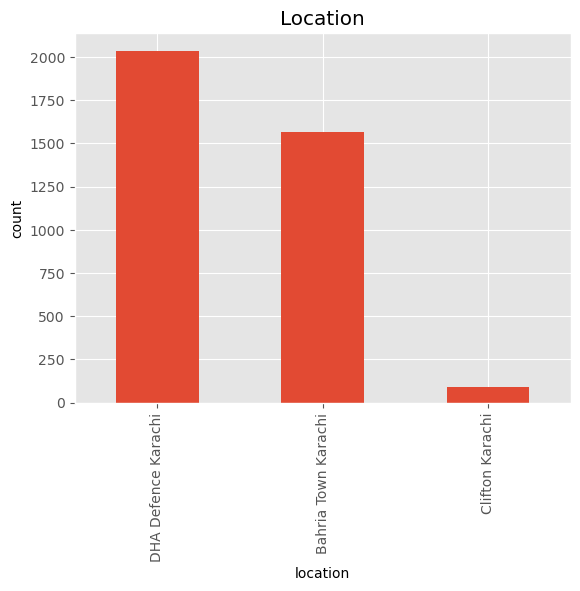

In [7]:
ax = df['location'].value_counts()\
.plot(kind='bar', title = "Location")
ax.set_xlabel("location")
ax.set_ylabel("count");

In [8]:
df.describe()["area"]

count    3695.000000
mean      404.218403
std       252.071496
min        75.000000
25%       200.000000
50%       350.000000
75%       500.000000
max      1000.000000
Name: area, dtype: float64

In [9]:
df["area"].quantile([0.1, 0.9])


0.1    125.0
0.9    800.0
Name: area, dtype: float64

In [10]:
df["bedrooms"].value_counts()

3     1050
6      885
4      829
5      756
7      101
8       33
9       17
2       16
10       6
1        1
11       1
Name: bedrooms, dtype: int64

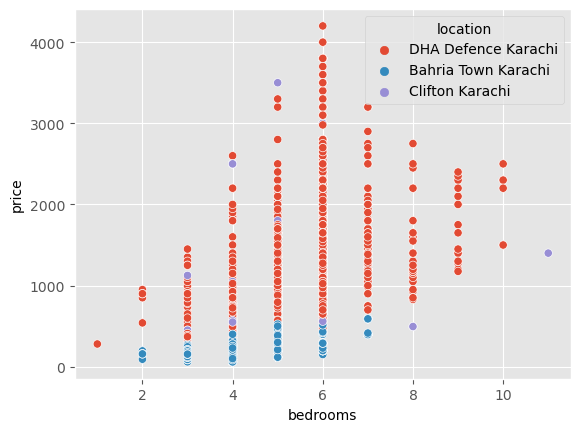

In [11]:
sns.scatterplot(x = "bedrooms",
                y = "price",
                hue = "location",
               data = df);

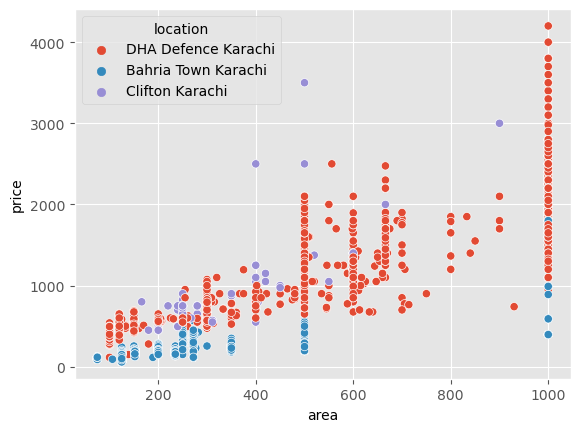

In [12]:
sns.scatterplot(x = "area",
                y = "price",
                hue = "location",
               data = df);

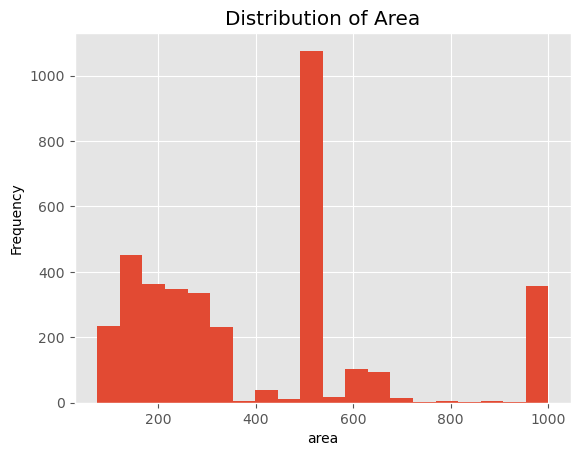

In [13]:
ax = df['area'].plot(kind="hist", 
                          bins=20, 
                          title = "Distribution of Area")
ax.set_xlabel("area")
ax.set_ylabel("Frequency");

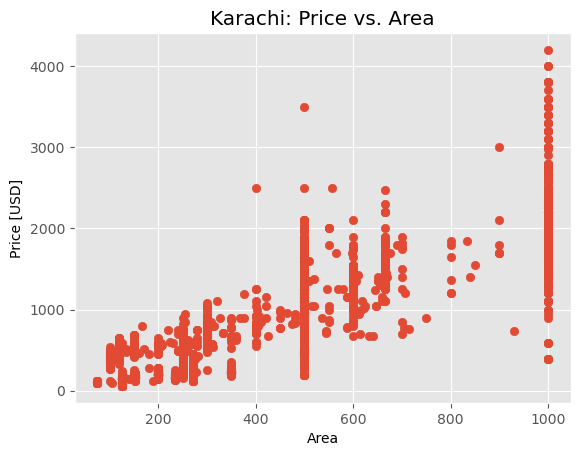

In [14]:
plt.scatter(x=df["area"], y=df["price"])
plt.xlabel("Area")
plt.ylabel("Price [USD]")
plt.title("Karachi: Price vs. Area");

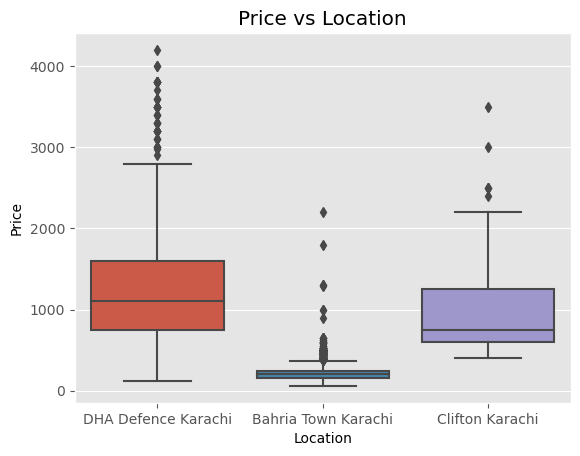

In [15]:
sns.boxplot(x="location", y="price", data=df)
plt.xlabel("Location")
plt.ylabel("Price")
plt.title("Price vs Location");

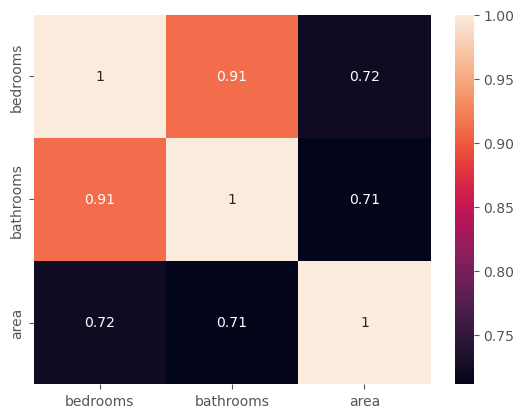

In [16]:
#graphical representation
corr = df.select_dtypes("number").drop(columns ="price").corr()
sns.heatmap(corr, annot = True);

In [17]:
df.head()

,price,type,bedrooms,bathrooms,area,location
0,1150.0,House,5,6,600.0,DHA Defence Karachi
5,900.0,House,7,6,500.0,DHA Defence Karachi
11,2000.0,House,6,6,1000.0,DHA Defence Karachi
14,1700.0,House,6,6,500.0,DHA Defence Karachi
16,725.0,House,3,4,545.0,DHA Defence Karachi


In [18]:
target = "price"
features = ["bedrooms","bathrooms","area","location"]
y = df[target]
X = df[features]

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

In [20]:
y_mean = y_train.mean()
y_pred_baseline = [y_mean] * len(y_train)
print("Mean apt price:", round(y_mean, 2))
print("Baseline MAE:", mean_absolute_error(y_train, y_pred_baseline))

Mean apt price: 799.45
Baseline MAE: 554.293908044188


In [21]:
model = make_pipeline(
     OneHotEncoder(use_cat_names=True),
     LinearRegression()
)
model.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['location'], use_cat_names=True)),
                ('linearregression', LinearRegression())])

In [22]:
y_pred_training = model.predict(X_train)
print("Training MAE:", mean_absolute_error(y_train, y_pred_training))

Training MAE: 200.03383427457152


In [23]:
y_pred_test = pd.Series(model.predict(X_test))
y_pred_test.head()

0      36.131844
1     787.144003
2     187.747627
3     694.538141
4    1175.199265
dtype: float64

In [24]:
def make_prediction(bedrooms, bathrooms, area, location):
    data = {
        "bedrooms":bedrooms,
        "bathrooms":bathrooms,
        "area":area,
        "location":location
    }
    df = pd.DataFrame(data, index=[0])
    prediction = model.predict(df).round(2)[0]
    return f"Predicted house price: ${prediction}"

In [25]:
make_prediction(5,6,6009.0,"DHA Defence Karachi")

'Predicted house price: $11282.2'